In [23]:
import os
os.makedirs('../models',exist_ok=True)
os.makedirs('../reports/figures',exist_ok=True)

In [24]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, GridSearchCV,StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix,make_scorer
from xgboost import XGBClassifier
import joblib
import warnings
warnings.filterwarnings('ignore')


In [25]:
df = pd.read_csv('../data/processed/engineered_merged.csv')
print(df['label'].value_counts())





X = df.drop('label', axis=1)
y = df['label']
X_train = pd.read_csv('../data/processed/X_train.csv').values
X_val = pd.read_csv('../data/processed/X_val.csv').values
X_test = pd.read_csv('../data/processed/X_test.csv').values
y_train = pd.read_csv('../data/processed/y_train.csv')['label_encoded'].values
y_val = pd.read_csv('../data/processed/y_val.csv')['label_encoded'].values
y_test = pd.read_csv('../data/processed/y_test.csv')['label_encoded'].values

# Load label encoder for later decoding
le = joblib.load('../models/label_encoder.pkl')

print("Train shape:", X_train.shape, y_train.shape)

label
Major_Cereals    3210
Pulses            347
Specialty         167
Cereals           143
Name: count, dtype: int64
Train shape: (2706, 11) (2706,)


In [26]:
X_train = pd.read_csv('../data/processed/X_train_merged.csv').values
X_val = pd.read_csv('../data/processed/X_val_merged.csv').values
X_test = pd.read_csv('../data/processed/X_test_merged.csv').values
y_train = pd.read_csv('../data/processed/y_train_merged.csv')['label_encoded'].values
y_val = pd.read_csv('../data/processed/y_val_merged.csv')['label_encoded'].values
y_test = pd.read_csv('../data/processed/y_test_merged.csv')['label_encoded'].values

# Label encoder
le = joblib.load('../models/label_encoder_merged.pkl')

In [27]:
# Dictionary to store results
results = {}

# 1. Logistic Regression
logreg = LogisticRegression(max_iter=1000, solver='lbfgs',class_weight='balanced')  # Explicit solver for better multi-class handling
cv_scores = cross_val_score(logreg, X_train, y_train, cv=5, scoring='f1_macro')
results['Logistic Regression'] = {'CV F1 Macro': cv_scores.mean()}

logreg.fit(X_train, y_train)
val_pred = logreg.predict(X_val)
results['Logistic Regression']['Val Accuracy'] = accuracy_score(y_val, val_pred)
results['Logistic Regression']['Val F1 Macro'] = f1_score(y_val, val_pred, average='macro')

# 2. Decision Tree
dt = DecisionTreeClassifier(random_state=42,class_weight='balanced')
cv_scores = cross_val_score(dt, X_train, y_train, cv=5, scoring='f1_macro')
results['Decision Tree'] = {'CV F1 Macro': cv_scores.mean()}

dt.fit(X_train, y_train)
val_pred = dt.predict(X_val)
results['Decision Tree']['Val Accuracy'] = accuracy_score(y_val, val_pred)
results['Decision Tree']['Val F1 Macro'] = f1_score(y_val, val_pred, average='macro')

# 3. Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42,class_weight='balanced')
cv_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='f1_macro')
results['Random Forest'] = {'CV F1 Macro': cv_scores.mean()}

rf.fit(X_train, y_train)
val_pred = rf.predict(X_val)
results['Random Forest']['Val Accuracy'] = accuracy_score(y_val, val_pred)
results['Random Forest']['Val F1 Macro'] = f1_score(y_val, val_pred, average='macro')

# 4. XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42,class_weight='balanced')
cv_scores = cross_val_score(xgb, X_train, y_train, cv=5, scoring='f1_macro')
results['XGBoost'] = {'CV F1 Macro': cv_scores.mean()}

xgb.fit(X_train, y_train)
val_pred = xgb.predict(X_val)
results['XGBoost']['Val Accuracy'] = accuracy_score(y_val, val_pred)
results['XGBoost']['Val F1 Macro'] = f1_score(y_val, val_pred, average='macro')

# Results table
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values('Val F1 Macro', ascending=False)
print("\nModel Comparison:")
print(results_df.round(4))
results_df.to_csv('../reports/model_comparison.csv')


Model Comparison:
                     CV F1 Macro  Val Accuracy  Val F1 Macro
XGBoost                   0.5923        0.8186        0.6074
Random Forest             0.5857        0.8129        0.5558
Decision Tree             0.5153        0.7129        0.5244
Logistic Regression       0.2885        0.2814        0.2643


In [7]:
# Hyperparameter Tuning with SMOTE Pipeline for Imbalance
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV

print("Tuning Random Forest with SMOTE pipeline...")

# Pipeline: SMOTE first (only on train folds), then RF
pipe = ImbPipeline([
    ('smote', SMOTE(random_state=42, k_neighbors=3)),  # k_neighbors=3 to handle very rare classes
    ('rf', RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced'))  # Add balanced weights for extra boost
])

param_grid = {
    'smote__k_neighbors': [3, 5], 
    'rf__n_estimators': [200, 300, 400],
    'rf__max_depth': [20, 30, None],
    'rf__min_samples_split': [2, 5],
    'rf__min_samples_leaf': [1, 2]
}

grid = GridSearchCV(
    pipe, 
    param_grid, 
    cv=5, 
    scoring='f1_macro',  # Focus on macro for imbalance
    verbose=2, 
    n_jobs=-1
)

grid.fit(X_train, y_train)

best_rf = grid.best_estimator_
print("Best params:", grid.best_params_)
print("Best CV F1 Macro:", grid.best_score_)

# Validate tuned model (no SMOTE on val—pipeline handles it)
val_pred = best_rf.predict(X_val)
print("Tuned Val Accuracy:", accuracy_score(y_val, val_pred))
print("Tuned Val F1 Macro:", f1_score(y_val, val_pred, average='macro'))

Tuning Random Forest with SMOTE pipeline...
Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV] END rf__max_depth=20, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=200, smote__k_neighbors=3; total time=   4.2s
[CV] END rf__max_depth=20, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=300, smote__k_neighbors=3; total time=   5.9s
[CV] END rf__max_depth=20, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=300, smote__k_neighbors=5; total time=   8.7s
[CV] END rf__max_depth=20, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=400, smote__k_neighbors=5; total time=  11.1s
[CV] END rf__max_depth=20, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=200, smote__k_neighbors=5; total time=   4.0s
[CV] END rf__max_depth=20, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=300, smote__k_neighbors=3; total time=   6.7s
[CV] END rf__max_depth=20, rf__min_samples_leaf=1, rf__min_s

In [28]:
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV 
from scipy.stats import randint, uniform

print("Tuning Balanced Random Forest...")

# Balanced RF handles imbalance automatically
brf = BalancedRandomForestClassifier(random_state=42, n_jobs=-1, sampling_strategy='auto')

param_dist = {
    'n_estimators': randint(200, 600),
    'max_depth': [None, 20, 30, 40],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 4),
    'max_features': uniform(0.5, 0.5) 
}

random_search = RandomizedSearchCV(
    brf, 
    param_distributions=param_dist, 
    n_iter=50,  
    cv=5, 
    scoring='f1_macro', 
    verbose=2, 
    random_state=42, 
    n_jobs=-1
)

random_search.fit(X_train, y_train)

best_brf = random_search.best_estimator_
print("Best params:", random_search.best_params_)
print("Best CV F1 Macro:", random_search.best_score_)

# Validate
val_pred = best_brf.predict(X_val)
print("Tuned Val Accuracy:", accuracy_score(y_val, val_pred))
print("Tuned Val F1 Macro:", f1_score(y_val, val_pred, average='macro'))
print(classification_report(y_val, val_pred, target_names=le.classes_))

Tuning Balanced Random Forest...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END max_depth=30, max_features=0.8982714934301164, min_samples_leaf=3, min_samples_split=4, n_estimators=271; total time=   3.5s
[CV] END max_depth=None, max_features=0.7984250789732434, min_samples_leaf=2, min_samples_split=4, n_estimators=414; total time=   5.4s
[CV] END max_depth=40, max_features=0.8254442364744264, min_samples_leaf=1, min_samples_split=3, n_estimators=543; total time=   7.7s
[CV] END max_depth=None, max_features=0.6521211214797689, min_samples_leaf=2, min_samples_split=6, n_estimators=435; total time=   5.3s
[CV] END max_depth=None, max_features=0.645614570099021, min_samples_leaf=3, min_samples_split=8, n_estimators=369; total time=   4.0s
[CV] END max_depth=20, max_features=0.5998368910791798, min_samples_leaf=3, min_samples_split=5, n_estimators=519; total time=   5.5s
[CV] END max_depth=30, max_features=0.8982714934301164, min_samples_leaf=3, min_samples_split=4,

In [31]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from scipy.stats import randint, uniform

print("Tuning XGBoost with SMOTE (fast randomized search)...")

pipe = ImbPipeline([
    ('smote', SMOTE(random_state=42, k_neighbors=3)),
    ('xgb', XGBClassifier(
        random_state=42,
        eval_metric='mlogloss',
        n_jobs=-1,
        use_label_encoder=False
    ))
])


param_dist = {
    'smote__k_neighbors': [3, 5],
    'xgb__n_estimators': randint(200, 500),        # 200–499
    'xgb__max_depth': randint(5, 12),              # 5–11
    'xgb__learning_rate': uniform(0.05, 0.2),      # 0.05–0.25
    'xgb__subsample': uniform(0.7, 0.3),           # 0.7–1.0
    'xgb__colsample_bytree': uniform(0.7, 0.3),    # 0.7–1.0
    'xgb__min_child_weight': randint(1, 6),        # 1–6
    'xgb__gamma': [0, 0.1, 0.2]
}

random_search = RandomizedSearchCV(
    pipe,
    param_distributions=param_dist,
    n_iter=30,              # Only 30 random combinations (key for speed)
    cv=5,
    scoring='f1_macro',
    verbose=2,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)

best_xgb = random_search.best_estimator_
print("Best params:", random_search.best_params_)
print("Best CV F1 Macro:", random_search.best_score_)

# Validation
val_pred = best_xgb.predict(X_val)
print("Tuned Val Accuracy:", accuracy_score(y_val, val_pred))
print("Tuned Val F1 Macro:", f1_score(y_val, val_pred, average='macro'))
print("\nClassification Report on Val:")
print(classification_report(y_val, val_pred, target_names=le.classes_))

Tuning XGBoost with SMOTE (fast randomized search)...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best params: {'smote__k_neighbors': 3, 'xgb__colsample_bytree': np.float64(0.9526854323784995), 'xgb__gamma': 0.1, 'xgb__learning_rate': np.float64(0.12903004720036287), 'xgb__max_depth': 8, 'xgb__min_child_weight': 4, 'xgb__n_estimators': 389, 'xgb__subsample': np.float64(0.7975990992289792)}
Best CV F1 Macro: 0.6394822518946196
Tuned Val Accuracy: 0.8014285714285714
Tuned Val F1 Macro: 0.6472301602342796

Classification Report on Val:
               precision    recall  f1-score   support

      Cereals       0.84      0.67      0.74        81
Major_Cereals       0.84      0.91      0.88       482
       Pulses       0.24      0.23      0.24        52
    Specialty       0.86      0.64      0.73        85

     accuracy                           0.80       700
    macro avg       0.70      0.61      0.65       700
 weighted avg       0.80      0.80      0.80       700




FINAL TEST RESULTS (XGBoost + SMOTE):
Test Accuracy: 0.8046
Test F1 Macro: 0.6828
Test F1 Weighted: 0.8066

Classification Report (Test Set):
               precision    recall  f1-score   support

      Cereals       0.83      0.76      0.79        82
Major_Cereals       0.85      0.89      0.87       482
       Pulses       0.26      0.31      0.28        52
    Specialty       0.94      0.68      0.79        85

     accuracy                           0.80       701
    macro avg       0.72      0.66      0.68       701
 weighted avg       0.81      0.80      0.81       701



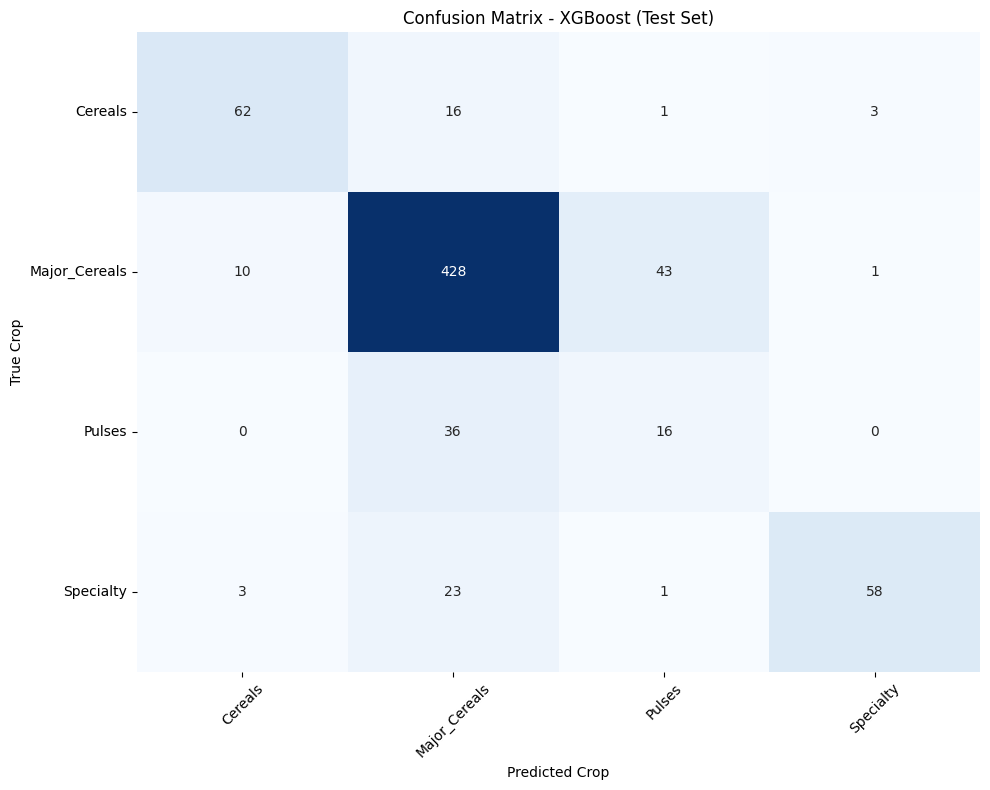

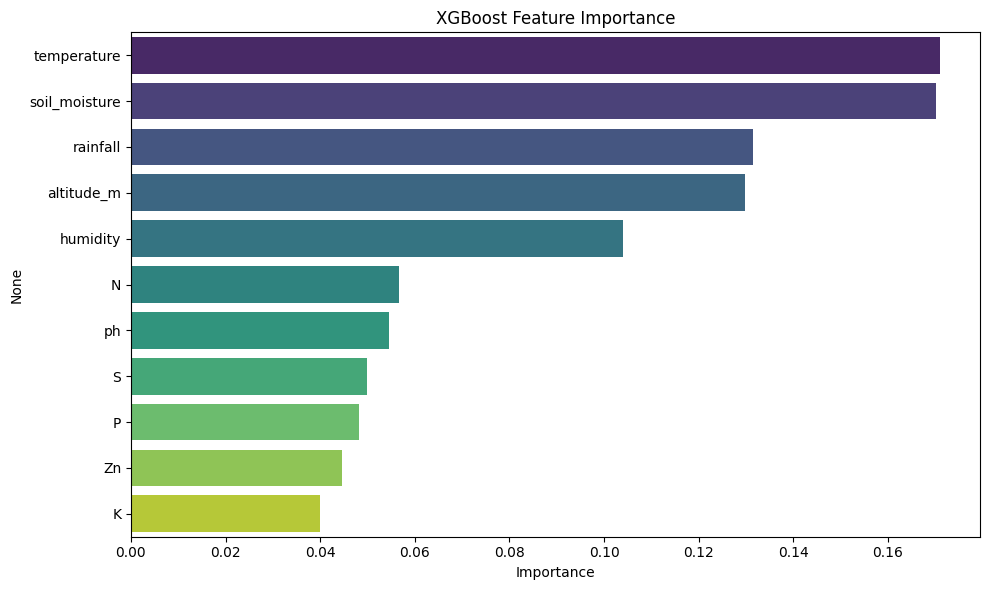


Final XGBoost + SMOTE pipeline saved as 'best_crop_model.pkl'


In [32]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import numpy as np

# Combine train + val
X_train_full = np.vstack([X_train, X_val])
y_train_full = np.hstack([y_train, y_val])

# Resample full training data with SMOTE (using same params as best)
smote = SMOTE(random_state=42, k_neighbors=best_xgb.named_steps['smote'].k_neighbors)
X_train_full_res, y_train_full_res = smote.fit_resample(X_train_full, y_train_full)

# Fit only the XGBoost part on resampled data
best_xgb_model = best_xgb.named_steps['xgb']
best_xgb_model.fit(X_train_full_res, y_train_full_res)

# Test predictions
test_pred = best_xgb_model.predict(X_test)

test_acc = accuracy_score(y_test, test_pred)
test_f1_macro = f1_score(y_test, test_pred, average='macro')
test_f1_weighted = f1_score(y_test, test_pred, average='weighted')

print(f"\nFINAL TEST RESULTS (XGBoost + SMOTE):")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test F1 Macro: {test_f1_macro:.4f}")
print(f"Test F1 Weighted: {test_f1_weighted:.4f}")

print("\nClassification Report (Test Set):")
print(classification_report(y_test, test_pred, target_names=le.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, test_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_,
            cmap='Blues', cbar=False)
plt.title('Confusion Matrix - XGBoost (Test Set)')
plt.ylabel('True Crop')
plt.xlabel('Predicted Crop')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('../reports/figures/confusion_matrix_xgboost_final.png')
plt.show()

# Feature Importance (XGBoost)
importances = best_xgb_model.feature_importances_
feat_imp = pd.Series(importances, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feat_imp.values, y=feat_imp.index, palette='viridis')
plt.title('XGBoost Feature Importance')
plt.xlabel('Importance')
plt.tight_layout()
plt.savefig('../reports/figures/feature_importance_xgboost.png')
plt.show()

# Save the full pipeline (includes SMOTE for consistent deployment)
joblib.dump(best_xgb, '../models/best_crop_model.pkl')
print("\nFinal XGBoost + SMOTE pipeline saved as 'best_crop_model.pkl'")

